# DINOv3 Feature Extraction - CSV Dataset Version

**Extract and visualize features from CSV-based image datasets using DINOv3 models.**

This notebook provides comprehensive feature extraction and visualization specifically designed for CSV datasets.

### Key Features:
- **CSV Dataset Support**: Load datasets from CSV files with image paths
- **Automatic Label Extraction**: Extracts cell type labels from filenames
- **Dual Model Comparison**: Compare original pretrained vs fine-tuned DINOv3
- **Dimensionality Reduction**: PCA, t-SNE, and UMAP visualizations
- **Interactive Analysis**: Color-coded by cell types

### CSV Format:
Your CSV file should have:
- **Image path column**: Path to each image file

Example CSV:
```
magnification,image_path
10X,/path/to/coord_0_0_Bcell_state_None_lvl_2.tiff
10X,/path/to/coord_0_0_CTL_CD8+KI67+_state_None_lvl_5.tiff
```

Labels are automatically extracted from filenames:
- `coord_0_0_Bcell_state_None_lvl_2.tiff` → **Bcell**
- `CTL_CD8+KI67+_state_None_lvl_5.tiff` → **CTL_CD8+KI67+**

In [1]:
# Import libraries and setup
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Deep learning libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("UMAP not available. Install with: pip install umap-learn")

# Setup paths
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
sys.path.insert(0, project_root)
dinov3_path = os.path.join(project_root, "dinov3")
sys.path.insert(0, dinov3_path)

# Import custom modules
from data.csv_dataset import CSVDataset
from src.models.dinov3_lightning_model import DINOv3LightningModule

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")

# Professional plotting style
plt.style.use('default')
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
})

print("✓ Libraries loaded successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

/home/marjans/anaconda3/envs/dlv2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda
✓ Libraries loaded successfully
PyTorch version: 2.8.0+cu128
CUDA available: True


## 📊 Configuration

Configure your feature extraction settings below.

In [2]:
# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Configuration for feature extraction"""
    
    # Model Selection
    USE_ORIGINAL_MODEL = True   # Extract features from original pretrained DINOv3
    USE_FINETUNED_MODEL = True  # Extract features from fine-tuned DINOv3
    
    # CSV Dataset Configuration
    CSV_PATH = '../patches.csv'             # Path to CSV file
    CSV_IMAGE_COL = 'image_path'         # Column name containing image paths
    CSV_SEPARATOR = ','                  # CSV separator character
    CSV_BASE_PATH = None                 # Base path for relative image paths (None = CSV dir)
    
    # Sampling (set to None to use all data)
    MAX_SAMPLES = None  # Maximum number of samples to process (None = all)
    
    # Feature Extraction
    BATCH_SIZE = 32     # Batch size for feature extraction
    NUM_WORKERS = 4     # DataLoader workers
    
    # Dimensionality Reduction
    USE_PCA = True      # Compute PCA
    USE_TSNE = True     # Compute t-SNE
    USE_UMAP = True     # Compute UMAP (if available)
    
    PCA_COMPONENTS = 50  # Number of PCA components
    TSNE_PERPLEXITY = 30 # t-SNE perplexity
    UMAP_NEIGHBORS = 15  # UMAP n_neighbors
    
    RANDOM_SEED = 42     # For reproducibility

# Get project root
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)

# Model paths
MODEL_PATHS = {
    'original': os.path.join(project_root, 'dinov3_official_weights', 'dinov3_vits16_pretrain_lvd1689m-08c60483.pth'),
    'finetuned': os.path.join(project_root, 'output', 'checkpoints', 'model_epoch_epoch=244_step_step=156000_loss_total_loss=6.609375.ckpt'),
    'config': os.path.join(project_root, 'configs', 'config_lightning_finetuning_v2.yaml')
}

# Output directory
OUTPUT_DIR = Path('./feature_extraction_results')
OUTPUT_DIR.mkdir(exist_ok=True)

# Set random seeds
torch.manual_seed(Config.RANDOM_SEED)
np.random.seed(Config.RANDOM_SEED)

print("Configuration:")
print(f"  CSV file: {Config.CSV_PATH}")
print(f"  Image column: {Config.CSV_IMAGE_COL}")
print(f"  Max samples: {Config.MAX_SAMPLES or 'All'}")
print(f"  Batch size: {Config.BATCH_SIZE}")
print(f"  Models: Original={Config.USE_ORIGINAL_MODEL}, Fine-tuned={Config.USE_FINETUNED_MODEL}")
print(f"  Dimensionality reduction: PCA={Config.USE_PCA}, t-SNE={Config.USE_TSNE}, UMAP={Config.USE_UMAP}")
print(f"  Output directory: {OUTPUT_DIR}")
print("="*70)

Configuration:
  CSV file: ../patches.csv
  Image column: image_path
  Max samples: All
  Batch size: 32
  Models: Original=True, Fine-tuned=True
  Dimensionality reduction: PCA=True, t-SNE=True, UMAP=True
  Output directory: feature_extraction_results


## 📁 CSV Dataset Manager

Load CSV dataset and extract labels from filenames.

In [3]:
class CSVDatasetManager:
    """Dataset manager for CSV-based datasets with label extraction from filenames"""
    
    def __init__(self, config):
        self.config = config
        self.dataset = None
        self.label_names = {}
        self.label_to_idx = {}
        self.sample_labels = []
        
        # Standard image transforms for DINOv3
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def extract_label_from_filename(self, filepath):
        """
        Extract label from filename pattern:
        coord_0_0_Bcell_state_None_lvl_2.tiff -> Bcell
        CTL_CD8+KI67+_state_None_lvl_5.tiff -> CTL_CD8+KI67+
        """
        filename = Path(filepath).stem  # Remove extension
        
        # Find the label part: everything before "_state_"
        if '_state_' in filename:
            # Split by _state_ and take the part before
            before_state = filename.split('_state_')[0]
            
            # Remove coordinate prefix if present (coord_X_Y_)
            if before_state.startswith('coord_'):
                # Format: coord_0_0_LABEL
                parts = before_state.split('_')
                # Skip 'coord', x, y and take the rest
                if len(parts) > 3:
                    label = '_'.join(parts[3:])
                else:
                    label = before_state
            else:
                label = before_state
        else:
            # Fallback: use filename
            label = filename
        
        return label
    
    def load_dataset(self):
        """Load CSV dataset"""
        print("\nCSV Dataset Loading")
        print("="*70)
        print(f"Loading from: {self.config.CSV_PATH}")
        
        # Load CSV dataset
        self.dataset = CSVDataset(
            csv_path=self.config.CSV_PATH,
            image_col=self.config.CSV_IMAGE_COL,
            label_col=None,  # Don't use CSV labels, extract from filename
            transform=self.transform,
            separator=self.config.CSV_SEPARATOR,
            skip_missing=True,
            base_path=self.config.CSV_BASE_PATH
        )
        
        print(f"✓ CSV dataset loaded: {len(self.dataset)} samples")
        
        # Extract labels from filenames
        print("\nExtracting labels from filenames...")
        all_labels = []
        for idx in range(len(self.dataset)):
            img_path = self.dataset.df.iloc[idx][self.config.CSV_IMAGE_COL]
            label = self.extract_label_from_filename(img_path)
            all_labels.append(label)
        
        # Create label mapping
        unique_labels = sorted(set(all_labels))
        self.label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
        self.label_names = {idx: label for idx, label in enumerate(unique_labels)}
        
        # Store labels for each sample
        self.sample_labels = [self.label_to_idx[label] for label in all_labels]
        
        print(f"✓ Found {len(unique_labels)} unique labels")
        print(f"  Labels: {unique_labels[:10]}{'...' if len(unique_labels) > 10 else ''}")
        
        # Print label distribution
        from collections import Counter
        label_counts = Counter(all_labels)
        print(f"\nLabel distribution:")
        for label in unique_labels[:5]:
            count = label_counts[label]
            print(f"  {label}: {count} samples")
        if len(unique_labels) > 5:
            print(f"  ... and {len(unique_labels) - 5} more labels")
        
        # Apply max samples limit if specified
        if self.config.MAX_SAMPLES and len(self.dataset) > self.config.MAX_SAMPLES:
            print(f"\nLimiting to {self.config.MAX_SAMPLES} samples...")
            indices = np.random.choice(len(self.dataset), self.config.MAX_SAMPLES, replace=False)
            self.dataset.df = self.dataset.df.iloc[indices].reset_index(drop=True)
            self.sample_labels = [self.sample_labels[i] for i in indices]
            print(f"✓ Using {len(self.dataset)} samples")
        
        print("="*70)
        return self.dataset
    
    def get_dataloader(self):
        """Create dataloader"""
        return DataLoader(
            self.dataset,
            batch_size=self.config.BATCH_SIZE,
            shuffle=False,
            num_workers=self.config.NUM_WORKERS,
            pin_memory=True
        )

# Initialize and load dataset
dataset_manager = CSVDatasetManager(Config)
dataset = dataset_manager.load_dataset()
dataloader = dataset_manager.get_dataloader()

print(f"\n✓ Dataset ready: {len(dataset)} samples, {len(dataset_manager.label_names)} classes")
print(f"✓ DataLoader created: batch_size={Config.BATCH_SIZE}")

INFO:dinov3:Loading CSV dataset from: /home/marjans/DinoV3LightningTraining/patches.csv
INFO:dinov3:Loaded CSV with 81536 rows
INFO:dinov3:Available columns: ['magnification', 'image_path']



CSV Dataset Loading
Loading from: ../patches.csv


INFO:dinov3:Dataset initialized with 81536 images


✓ CSV dataset loaded: 81536 samples

Extracting labels from filenames...
✓ Found 14 unique labels
  Labels: ['Bcell', 'CD163_Macrophages', 'CTL_CD8+', 'CTL_CD8+KI67+', 'CTL_CD8+PD1', 'Discoverable', 'EndothelialCells', 'FAP+Fibroblasts', 'FibroblastCells', 'MacrophageCells']...

Label distribution:
  Bcell: 5824 samples
  CD163_Macrophages: 5824 samples
  CTL_CD8+: 5824 samples
  CTL_CD8+KI67+: 5824 samples
  CTL_CD8+PD1: 5824 samples
  ... and 9 more labels

✓ Dataset ready: 81536 samples, 14 classes
✓ DataLoader created: batch_size=32


## 🤖 Model Loading

Load DINOv3 models for feature extraction.

In [4]:
def load_original_model():
    """Load original pretrained DINOv3 model"""
    try:
        print("Loading original DINOv3 model...")
        
        dinov3_hub_path = os.path.join(project_root, 'dinov3')
        model = torch.hub.load(
            dinov3_hub_path,
            'dinov3_vits16',
            source='local',
            weights=MODEL_PATHS['original'],
            pretrained=True
        )
        
        model.to(DEVICE)
        model.eval()
        
        print("  ✓ Original model loaded successfully")
        return model
        
    except Exception as e:
        print(f"  ✗ Failed to load original model: {e}")
        return None

def load_finetuned_model():
    """Load fine-tuned DINOv3 Lightning model"""
    try:
        print("Loading fine-tuned DINOv3 model...")
        
        lightning_model = DINOv3LightningModule.load_from_checkpoint(
            MODEL_PATHS['finetuned'],
            cfg_path=MODEL_PATHS['config'],
            map_location=DEVICE,
            strict=True
        )
        
        # Extract teacher backbone for feature extraction
        model = lightning_model.ssl_model.teacher.backbone
        model.eval()
        
        print("  ✓ Fine-tuned model loaded successfully")
        return model
        
    except Exception as e:
        print(f"  ✗ Failed to load fine-tuned model: {e}")
        return None

# Load models based on configuration
print("\n" + "="*70)
print("MODEL LOADING")
print("="*70)

models = {}

if Config.USE_ORIGINAL_MODEL:
    original_model = load_original_model()
    if original_model is not None:
        models['original'] = original_model

if Config.USE_FINETUNED_MODEL:
    finetuned_model = load_finetuned_model()
    if finetuned_model is not None:
        models['finetuned'] = finetuned_model

print(f"\n✓ Loaded {len(models)} model(s): {list(models.keys())}")
print("="*70)

INFO:dinov3:using base=100 for rope new
INFO:dinov3:using min_period=None for rope new
INFO:dinov3:using max_period=None for rope new
INFO:dinov3:using normalize_coords=separate for rope new
INFO:dinov3:using shift_coords=None for rope new
INFO:dinov3:using rescale_coords=2 for rope new
INFO:dinov3:using jitter_coords=None for rope new
INFO:dinov3:using dtype=fp32 for rope new
INFO:dinov3:using mlp layer as FFN



MODEL LOADING
Loading original DINOv3 model...
  ✓ Original model loaded successfully
Loading fine-tuned DINOv3 model...


INFO:dinov3_lightning:Building DINOv3 SSL model...
INFO:dinov3:using base=100.0 for rope new
INFO:dinov3:using min_period=None for rope new
INFO:dinov3:using max_period=None for rope new
INFO:dinov3:using normalize_coords=separate for rope new
INFO:dinov3:using shift_coords=None for rope new
INFO:dinov3:using rescale_coords=None for rope new
INFO:dinov3:using jitter_coords=None for rope new
INFO:dinov3:using dtype=bf16 for rope new
INFO:dinov3:using mlp layer as FFN
INFO:dinov3:fp8 matmuls: OFF (disabled in config)
INFO:dinov3:using base=100.0 for rope new
INFO:dinov3:using min_period=None for rope new
INFO:dinov3:using max_period=None for rope new
INFO:dinov3:using normalize_coords=separate for rope new
INFO:dinov3:using shift_coords=None for rope new
INFO:dinov3:using rescale_coords=None for rope new
INFO:dinov3:using jitter_coords=None for rope new
INFO:dinov3:using dtype=bf16 for rope new
INFO:dinov3:using mlp layer as FFN
INFO:dinov3:fp8 matmuls: OFF (disabled in config)
INFO:dino

  ✓ Fine-tuned model loaded successfully

✓ Loaded 2 model(s): ['original', 'finetuned']


## 🔍 Feature Extraction

Extract CLS token features from loaded models.

In [5]:
def extract_features(model, dataloader, model_name):
    """Extract CLS token features from DINOv3 model"""
    features = []
    
    print(f"\nExtracting features from {model_name} model...")
    print(f"  Expected feature dimension: 384 (DINOv3 ViT-S/16 CLS token)")
    
    model.eval()
    with torch.no_grad():
        for images, _ in tqdm(dataloader, desc=f"Processing {model_name}"):
            images = images.to(DEVICE)
            
            # Forward pass
            outputs = model(images)
            
            # Extract CLS token features
            if hasattr(outputs, 'shape') and len(outputs.shape) == 2:
                cls_features = outputs
            else:
                cls_features = outputs[:, 0] if len(outputs.shape) > 2 else outputs
            
            features.append(cls_features.cpu().numpy())
    
    # Concatenate all features
    features = np.vstack(features)
    
    print(f"  ✓ Extracted {model_name} features: {features.shape}")
    print(f"  Feature statistics: mean={features.mean():.4f}, std={features.std():.4f}")
    
    return features

# Extract features from all loaded models
print("\n" + "="*70)
print("FEATURE EXTRACTION")
print("="*70)

all_features = {}

for model_name, model in models.items():
    features = extract_features(model, dataloader, model_name)
    all_features[model_name] = features

# Use the labels we extracted from filenames
labels = np.array(dataset_manager.sample_labels)

print(f"\n✓ Feature extraction complete!")
print(f"  Number of samples: {len(labels)}")
print(f"  Number of classes: {len(dataset_manager.label_names)}")
print(f"  Feature dimension: {list(all_features.values())[0].shape[1]}")
print("="*70)


FEATURE EXTRACTION

Extracting features from original model...
  Expected feature dimension: 384 (DINOv3 ViT-S/16 CLS token)


Processing original: 100%|██████████| 2548/2548 [00:40<00:00, 63.01it/s]


  ✓ Extracted original features: (81536, 384)
  Feature statistics: mean=0.0048, std=0.4867

Extracting features from finetuned model...
  Expected feature dimension: 384 (DINOv3 ViT-S/16 CLS token)


Processing finetuned: 100%|██████████| 2548/2548 [00:39<00:00, 64.95it/s]


  ✓ Extracted finetuned features: (81536, 384)
  Feature statistics: mean=-0.0017, std=0.5509

✓ Feature extraction complete!
  Number of samples: 81536
  Number of classes: 14
  Feature dimension: 384


## 📈 Dimensionality Reduction

Reduce feature dimensions for visualization using PCA, t-SNE, and UMAP.

In [6]:
print("\n" + "="*70)
print("DIMENSIONALITY REDUCTION")
print("="*70)

embeddings = {}
explained_variance = {}

for model_name, features in all_features.items():
    print(f"\nProcessing {model_name} features...")
    embeddings[model_name] = {}
    
    # PCA
    if Config.USE_PCA:
        print("  Computing PCA...")
        pca = PCA(n_components=min(Config.PCA_COMPONENTS, features.shape[0], features.shape[1]),
                  random_state=Config.RANDOM_SEED)
        pca_embedding = pca.fit_transform(features)
        embeddings[model_name]['PCA'] = pca_embedding[:, :2]  # First 2 components for viz
        explained_variance[model_name] = pca.explained_variance_ratio_[:2].sum()
        print(f"    ✓ PCA done. Explained variance (2D): {explained_variance[model_name]:.2%}")
    
    # t-SNE
    if Config.USE_TSNE:
        print("  Computing t-SNE...")
        # Use PCA-reduced features for t-SNE (faster)
        if Config.USE_PCA and pca_embedding.shape[1] > 50:
            tsne_input = pca_embedding
        else:
            tsne_input = features
        
        tsne = TSNE(n_components=2, perplexity=Config.TSNE_PERPLEXITY,
                    random_state=Config.RANDOM_SEED, verbose=0)
        tsne_embedding = tsne.fit_transform(tsne_input)
        embeddings[model_name]['t-SNE'] = tsne_embedding
        print(f"    ✓ t-SNE done")
    
    # UMAP
    if Config.USE_UMAP and UMAP_AVAILABLE:
        print("  Computing UMAP...")
        umap_model = umap.UMAP(n_components=2, n_neighbors=Config.UMAP_NEIGHBORS,
                               random_state=Config.RANDOM_SEED, verbose=False)
        umap_embedding = umap_model.fit_transform(features)
        embeddings[model_name]['UMAP'] = umap_embedding
        print(f"    ✓ UMAP done")
    elif Config.USE_UMAP and not UMAP_AVAILABLE:
        print("    ⚠ UMAP not available. Skipping.")

print(f"\n✓ Dimensionality reduction complete!")
print(f"  Methods computed: {list(embeddings[list(embeddings.keys())[0]].keys())}")
print("="*70)


DIMENSIONALITY REDUCTION

Processing original features...
  Computing PCA...
    ✓ PCA done. Explained variance (2D): 50.87%
  Computing t-SNE...
    ✓ t-SNE done
  Computing UMAP...
    ✓ UMAP done

Processing finetuned features...
  Computing PCA...
    ✓ PCA done. Explained variance (2D): 2.68%
  Computing t-SNE...
    ✓ t-SNE done
  Computing UMAP...
    ✓ UMAP done

✓ Dimensionality reduction complete!
  Methods computed: ['PCA', 't-SNE', 'UMAP']


## 🎨 Visualization

Visualize the reduced features colored by cell types.

In [7]:
def plot_embeddings_comparison(embeddings_dict, labels, label_names, method_name, explained_var=None):
    """
    Plot embeddings for all models side by side
    
    Args:
        embeddings_dict: Dict of {model_name: embedding_array}
        labels: Array of label indices
        label_names: Dict mapping label indices to names
        method_name: Name of dimensionality reduction method
        explained_var: Optional dict of explained variance for each model
    """
    n_models = len(embeddings_dict)
    fig, axes = plt.subplots(1, n_models, figsize=(7*n_models, 6))
    
    if n_models == 1:
        axes = [axes]
    
    # Create color map
    unique_labels = sorted(set(labels))
    n_classes = len(unique_labels)
    
    # Use a colormap with enough distinct colors
    if n_classes <= 10:
        cmap = plt.cm.tab10
    elif n_classes <= 20:
        cmap = plt.cm.tab20
    else:
        cmap = plt.cm.gist_rainbow
    
    colors = [cmap(i / n_classes) for i in range(n_classes)]
    label_colors = [colors[unique_labels.index(label)] for label in labels]
    
    for idx, (model_name, embedding) in enumerate(embeddings_dict.items()):
        ax = axes[idx]
        
        # Scatter plot
        scatter = ax.scatter(embedding[:, 0], embedding[:, 1],
                           c=label_colors, s=20, alpha=0.6, edgecolors='none')
        
        # Title
        title = f'{model_name.title()} Model'
        if explained_var and model_name in explained_var:
            title += f'\n(Explained Var: {explained_var[model_name]:.1%})'
        ax.set_title(title, fontsize=14, fontweight='bold')
        
        ax.set_xlabel(f'{method_name} 1', fontsize=12)
        ax.set_ylabel(f'{method_name} 2', fontsize=12)
        ax.grid(True, alpha=0.3)
    
    # Create legend
    if n_classes <= 20:  # Only show legend if not too many classes
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=colors[i], label=label_names[label])
                          for i, label in enumerate(unique_labels)]
        fig.legend(handles=legend_elements, loc='center left',
                  bbox_to_anchor=(1, 0.5), fontsize=10, title='Cell Types')
    else:
        fig.text(1.02, 0.5, f'{n_classes} classes\n(legend omitted)',
                ha='left', va='center', fontsize=10)
    
    plt.suptitle(f'{method_name} Visualization of DINOv3 Features',
                fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 0.9, 0.96])
    
    # Save figure
    save_path = OUTPUT_DIR / f'{method_name.lower()}_comparison.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"  Saved: {save_path}")
    
    plt.show()

print("✓ Visualization functions ready")

✓ Visualization functions ready


## 📊 Generate All Visualizations

Create comparison plots for all dimensionality reduction methods.


GENERATING VISUALIZATIONS

Generating PCA visualization...
  Saved: feature_extraction_results/pca_comparison.png


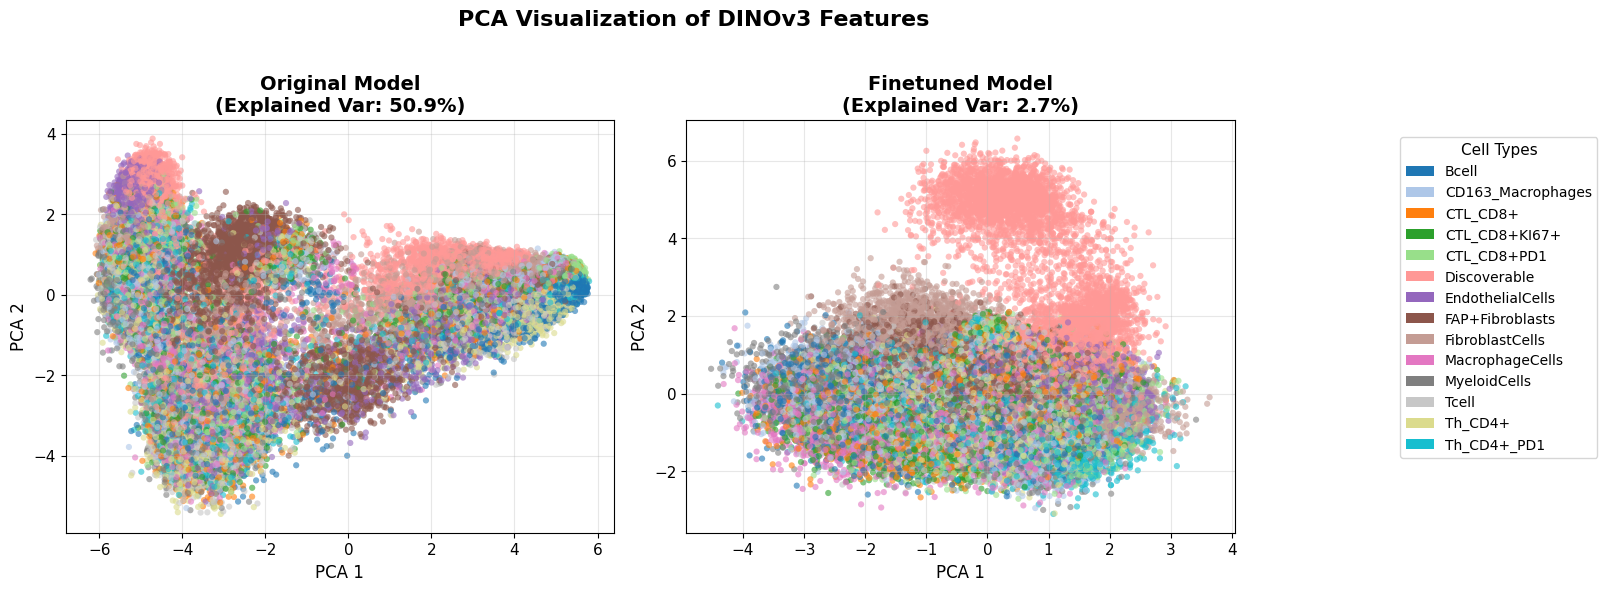


Generating t-SNE visualization...
  Saved: feature_extraction_results/t-sne_comparison.png


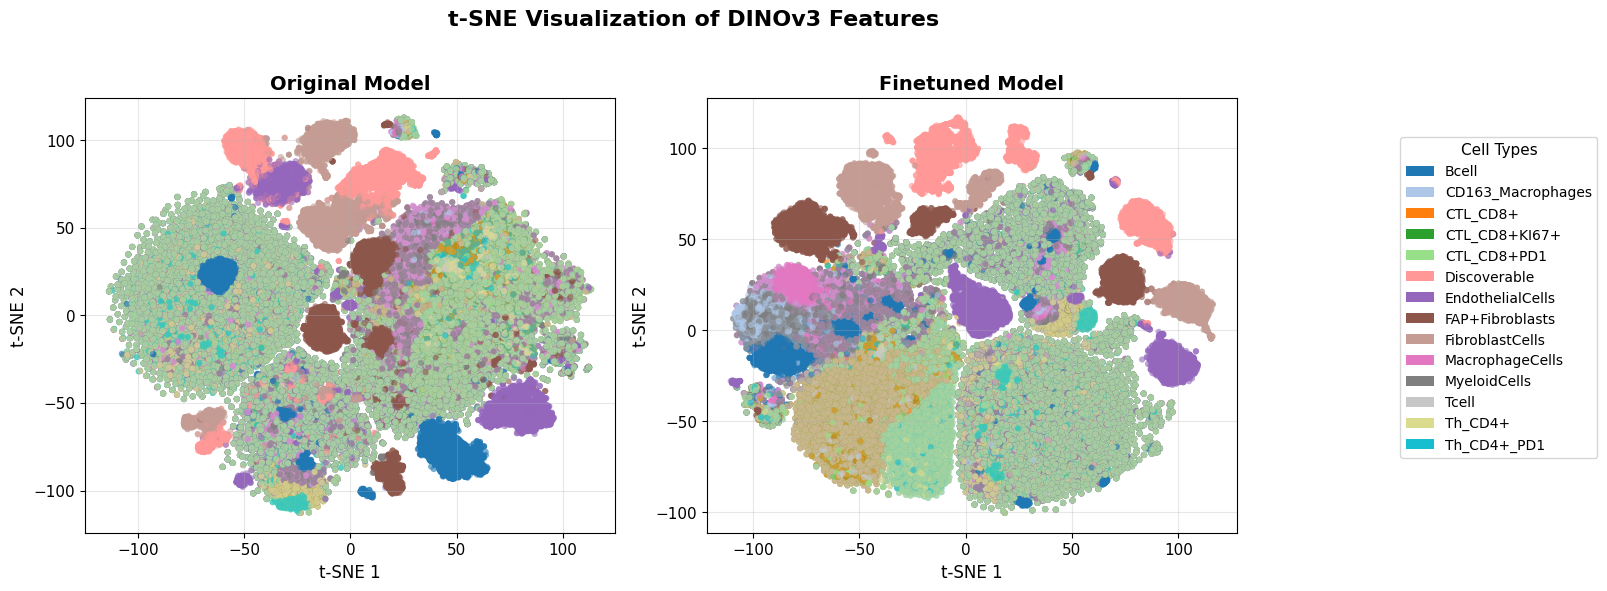


Generating UMAP visualization...
  Saved: feature_extraction_results/umap_comparison.png


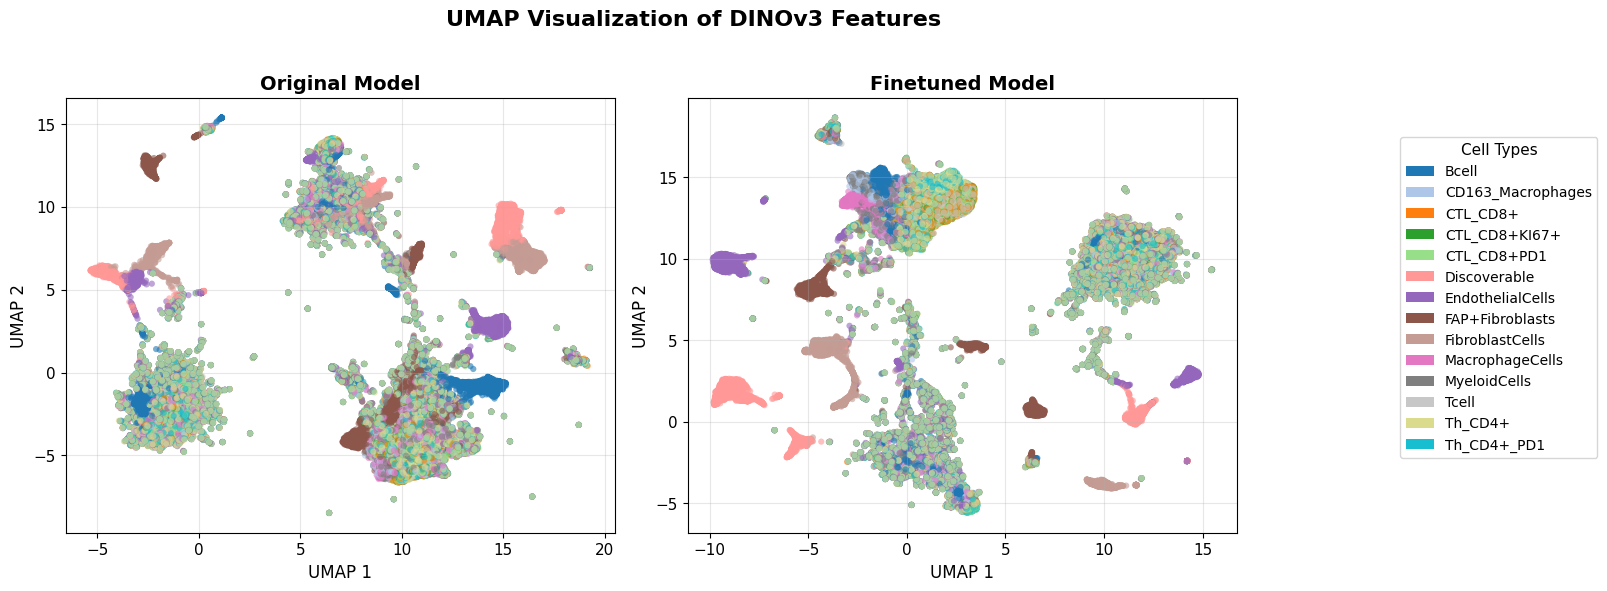


✓ All visualizations complete!
  Saved to: feature_extraction_results


In [8]:
print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Get all available methods
available_methods = list(embeddings[list(embeddings.keys())[0]].keys())

for method in available_methods:
    print(f"\nGenerating {method} visualization...")
    
    # Gather embeddings for this method from all models
    method_embeddings = {}
    for model_name in embeddings.keys():
        if method in embeddings[model_name]:
            method_embeddings[model_name] = embeddings[model_name][method]
    
    # Plot
    if method == 'PCA':
        plot_embeddings_comparison(method_embeddings, labels, dataset_manager.label_names,
                                  method, explained_variance)
    else:
        plot_embeddings_comparison(method_embeddings, labels, dataset_manager.label_names,
                                  method)

print(f"\n✓ All visualizations complete!")
print(f"  Saved to: {OUTPUT_DIR}")
print("="*70)

## 📋 Summary

Feature extraction and visualization complete!

### What was computed:
- ✓ Loaded CSV dataset with label extraction from filenames
- ✓ Extracted 384-dimensional CLS token features from DINOv3
- ✓ Applied dimensionality reduction (PCA, t-SNE, UMAP)
- ✓ Generated comparison visualizations

### Output files:
All visualizations are saved in the `feature_extraction_results/` directory.

### Interpretation:
- **Clusters**: Similar cell types should cluster together
- **Separation**: Well-separated clusters indicate good feature discrimination
- **Model comparison**: Compare how original vs fine-tuned models organize the feature space
- **Colors**: Each color represents a different cell type from your dataset